<a href="https://colab.research.google.com/github/Poomalaipradeep2006/poomalai-/blob/main/pradeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Sample of Generated Dataset ---
        PM2.5        PM10          O3         CO         NO2        SO2  \
0   96.762329   91.458489   59.724080  10.123275   87.939402  39.969917   
1  237.925005  248.436417   56.925972  11.970553  121.787688  47.870130   
2  184.338516  394.096168  182.188370   3.831972  115.223335  85.600192   
3  151.671329  332.178950   57.413778   9.410624   27.315486  34.660434   
4   43.224567  364.886905   61.670448   8.619015   26.641173  87.095319   

   Temperature   Humidity  WindSpeed       AQI_Level  
0    20.930278  22.909959   7.342545        Moderate  
1     1.895454  34.007940   7.029189            Good  
2    29.895783  82.343435   1.409665  Very Unhealthy  
3    19.524650  77.507627   9.264438        Moderate  
4     1.288155  46.298202   5.900486  Very Unhealthy  

--- AQI Level Distribution ---
AQI_Level
Very Unhealthy    489
Unhealthy         221
Good              177
Moderate          113
Name: count, dtype: int64

--- Training XGBoost Model

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:22:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Evaluating Model ---
Accuracy: 0.8640

Classification Report:
                precision    recall  f1-score   support

          Good       0.63      0.73      0.67        44
      Moderate       0.37      0.25      0.30        28
     Unhealthy       0.96      0.98      0.97        56
Very Unhealthy       0.99      1.00      1.00       122

      accuracy                           0.86       250
     macro avg       0.74      0.74      0.74       250
  weighted avg       0.85      0.86      0.86       250


Confusion Matrix:


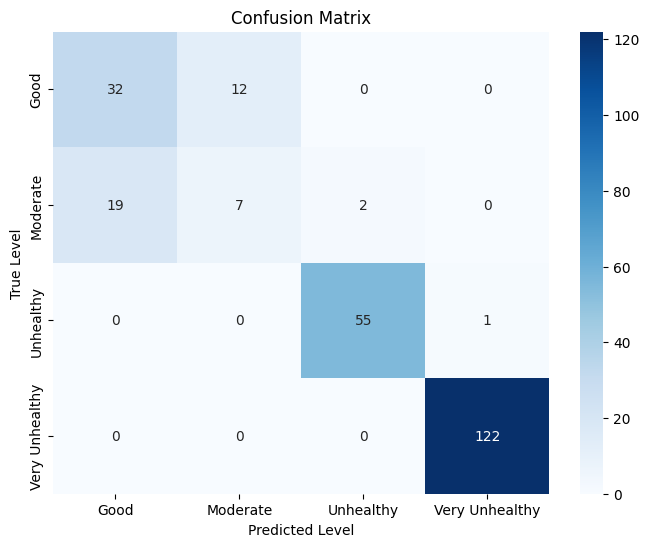


--- Feature Importances ---
       feature  importance
8    WindSpeed    0.379927
0        PM2.5    0.133479
3           CO    0.117408
2           O3    0.112761
1         PM10    0.106424
5          SO2    0.046236
7     Humidity    0.036662
4          NO2    0.033711
6  Temperature    0.033393


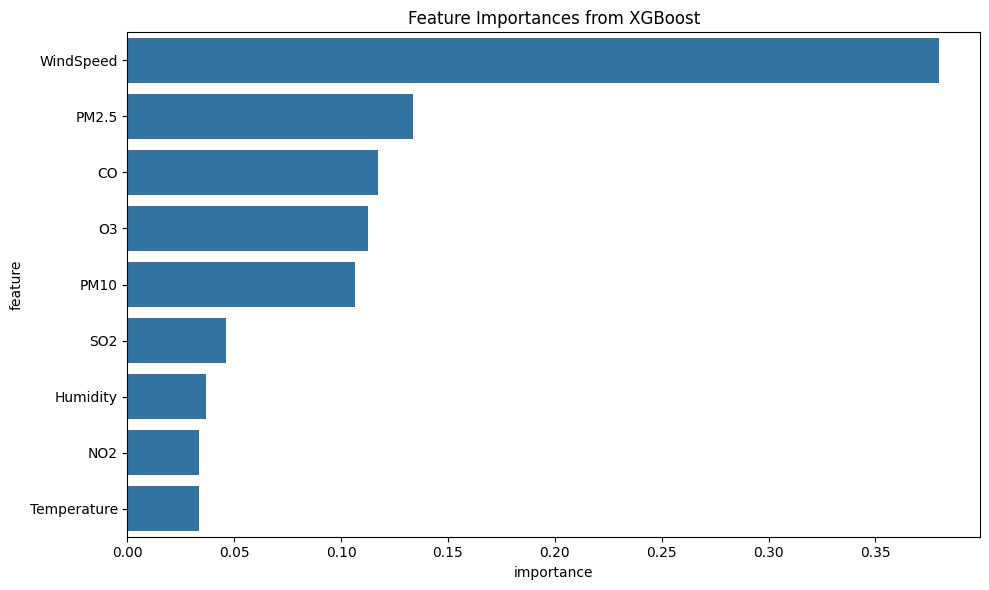


--- Predicting on New Sample Data ---

Input Data Sample 1:
PM2.5          25.0
PM10           40.0
O3             60.0
CO              2.0
NO2            30.0
SO2            10.0
Temperature    22.0
Humidity       55.0
WindSpeed       3.0
Name: 0, dtype: float64
Predicted AQI Level: Unhealthy

Input Data Sample 2:
PM2.5          160.0
PM10           300.0
O3             180.0
CO              10.0
NO2            100.0
SO2             70.0
Temperature     15.0
Humidity        85.0
WindSpeed        1.0
Name: 1, dtype: float64
Predicted AQI Level: Very Unhealthy


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Generate Synthetic Dataset ---
np.random.seed(42)
num_samples = 1000

data = {
    'PM2.5': np.random.uniform(5, 250, num_samples),
    'PM10': np.random.uniform(10, 450, num_samples),
    'O3': np.random.uniform(10, 200, num_samples),
    'CO': np.random.uniform(0.1, 15, num_samples),
    'NO2': np.random.uniform(5, 150, num_samples),
    'SO2': np.random.uniform(1, 100, num_samples),
    'Temperature': np.random.uniform(-5, 35, num_samples),
    'Humidity': np.random.uniform(20, 95, num_samples),
    'WindSpeed': np.random.uniform(0.5, 10, num_samples)
}
df = pd.DataFrame(data)

conditions = [
    (df['PM2.5'] <= 12) & (df['PM10'] <= 54) & (df['O3'] <= 54) & (df['CO'] <= 4.4),
    (df['PM2.5'] <= 35.4) & (df['PM10'] <= 154) & (df['O3'] <= 70) & (df['CO'] <= 9.4),
    (df['PM2.5'] <= 150.4) & (df['PM10'] <= 354) & (df['O3'] <= 164) & (df['CO'] <= 12.4),
    (df['PM2.5'] > 150.4) | (df['PM10'] > 354) | (df['O3'] > 164) | (df['CO'] > 12.4)
]
levels = ['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy']
df['AQI_Level'] = np.select(conditions, levels, default='Moderate')

df.loc[df['WindSpeed'] > 7, 'AQI_Level'] = np.random.choice(
    ['Good', 'Moderate'], size=len(df[df['WindSpeed'] > 7]), p=[0.6, 0.4])
df.loc[(df['Humidity'] > 80) & (df['Temperature'] < 5) & (df['WindSpeed'] < 2),
       'AQI_Level'] = np.random.choice(['Unhealthy', 'Very Unhealthy'],
       size=len(df[(df['Humidity'] > 80) & (df['Temperature'] < 5) & (df['WindSpeed'] < 2)]), p=[0.6, 0.4])

print("--- Sample of Generated Dataset ---")
print(df.head())
print("\n--- AQI Level Distribution ---")
print(df['AQI_Level'].value_counts())

# --- 2. Data Preprocessing ---
X = df.drop('AQI_Level', axis=1)
y = df['AQI_Level']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. Model Training ---
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

print("\n--- Training XGBoost Model ---")
model.fit(X_train_scaled, y_train)

# --- 4. Model Evaluation ---
print("\n--- Evaluating Model ---")
y_pred_encoded = model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Level')
plt.ylabel('True Level')
plt.title('Confusion Matrix')
plt.show()

# --- 5. Feature Importance ---
print("\n--- Feature Importances ---")
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.tight_layout()
plt.show()

# --- 6. Prediction on New Data ---
print("\n--- Predicting on New Sample Data ---")
new_sample_data = pd.DataFrame({
    'PM2.5': [25, 160],
    'PM10': [40, 300],
    'O3': [60, 180],
    'CO': [2.0, 10.0],
    'NO2': [30, 100],
    'SO2': [10, 70],
    'Temperature': [22, 15],
    'Humidity': [55, 85],
    'WindSpeed': [3, 1]
})

new_sample_scaled = scaler.transform(new_sample_data)
new_predictions_encoded = model.predict(new_sample_scaled)
new_predictions = label_encoder.inverse_transform(new_predictions_encoded)

for i, row in new_sample_data.iterrows():
    print(f"\nInput Data Sample {i+1}:")
    print(row)
    print(f"Predicted AQI Level: {new_predictions[i]}")